# Sensitivity based on input conditioning

## The method: input conditioning and forward map
In this example, we analyse the sensitivity of the output model with respect to its inputs. Let $Y=g(\boldsymbol{X})$ be the scalar output of 
the model $g$ with vector input $\boldsymbol{X}$ with dimension $n_x \in \mathbb{N}$. 

Let $a < b$ be two real numbers. 
For any input index $i \in \{1, ..., n_x\}$, we 
consider the conditional distribution of the input $X_i \; | \; X_i \in [a, b]$.
The physical model is a forward function which maps to the conditional distribution of the output $Y | \; X_i \in [a, b]$. 
If the unconditional distribution of $Y$ is very different to the conditional distribution 
$Y | \; X_i \in [a, b]$, then this input is influential for this interval $[a,b]$ of the input.

It might be difficult to select particular values of the real numbers $a$ and $b$. 
In order to make the process easier, we can consider quantiles of $X$. 
Let $0 \leq \alpha \leq \beta \leq 1$ be two quantiles levels. 
Then we can compute $a = x_{i, \alpha}$ the $\alpha$ quantile of $X_i$ and 
$b = x_{i, \beta}$ its $\beta$ quantile. 
The conditional distribution that we consider is therefore $Y | \; X_i \in [x_{i, \alpha}, x_{i, \beta}]$. 

Selecting one particular interval of quantile levels can be, however, difficult in some cases. This is especially more difficult when we are interested on the central dispersion of the output. In this case, it might be interesting to consider not only one single quantile level, but several. For example, if we consider 5 different splits of the distribution of the output, it leads to the quantile levels $[0,0.2]$, $[0.2,0.4]$, $[0.4,0.6]$, $[0.6,0.8]$ and $[0.8,1]$. This way, the entire range of the output is considered.
Furthermore, since we consider quantiles of each input, we can compare the conditional distributions 
with each other.

We consider the same model presented in `demo_plot_event.ipynb`.

In [1]:
import otsensitivity as ots
import openturns as ot
import openturns.viewer as otv
from matplotlib import pylab as plt
import pylab as pl

## Python script

The next cell defines the flood model. 

In [2]:
def getFloodingInputDistribution():
    """
    Return the input distribution of the model.

    Return
    ------
    inputDistribution: ot.ComposedDistribution(4)
        The input distribution of the model
    """
    dist_Q = ot.Gumbel(558.0, 1013.0)
    dist_Q = ot.TruncatedDistribution(dist_Q, 0)
    dist_Q.setDescription(["Q"])
    dist_Ks = ot.Normal(30, 7.5)
    dist_Ks = ot.TruncatedDistribution(dist_Ks, 0)
    dist_Ks.setDescription(["Ks"])
    dist_Zv = ot.Uniform(49.0, 51.0)
    dist_Zv.setDescription(["Zv"])
    dist_Zm = ot.Uniform(54.0, 56.0)
    dist_Zm.setDescription(["Zm"])
    inputDistribution = ot.ComposedDistribution([dist_Q, dist_Ks, dist_Zv, dist_Zm])
    return inputDistribution


def getFloodingSample(sampleSize):
    """
    Return a sample from the physical model.

    Parameters
    ----------
    sampleSize: int
        The sample size.

    Return
    ------
    inputSample: ot.Sample(sampleSize, inputDimension)
        The input sample.
    outputSample: ot.Sample(sampleSize, outputDimension)
        The output sample.
    """
    # Workaround for https://github.com/openturns/openturns/pull/2358
    physicalModel = ot.SymbolicFunction(
        ["Q", "Ks", "Zv", "Zm"],
        ["H", "S"],
        "H := (Q / (Ks * 300.0 * sqrt((Zm - Zv) / 5000.0)))^(3.0 / 5.0); S := H + Zv - 58.5",
    )

    inputDistribution = getFloodingInputDistribution()
    inputSample = inputDistribution.getSample(sampleSize)
    outputSample = physicalModel(inputSample)
    return inputSample, outputSample

Then we generate a sample from this model. The sensitivity analysis method that we present in this example only uses a pair of (X, Y) samples.

In [3]:
ot.Log.Show(ot.Log.NONE)

sampleSize = 1000

inputSample, outputSample = getFloodingSample(sampleSize)
inputSample[:5]

,Q,Ks,Zv,Zm
0,1443.603,28.7113,50.38435,54.87103
1,2174.89,25.40898,50.59971,55.89556
2,626.1024,33.24892,49.84856,54.90653
3,325.8124,39.44916,50.66521,54.51094
4,981.3994,13.86486,49.98321,55.91527


In [4]:
outputSample[:5]

,H,S
0,2.809813,-5.305838
1,3.678812,-4.221473
2,1.503647,-7.147793
3,0.9955951,-6.83919
4,3.172596,-5.344195


## Conditioning on input Q

We chose to select the output depending on a quantile of the input $Q$. First, we condition on the inputs corresponding to the quantile levels in the interval $[0, 0.2]$. This range of input lead to a corresponding range of the output: this leads to the conditional distribution $S \; | \; Q \in [q_{0}, q_{0.2}]$ where $q_{0}$ is the quantile of level 0 of the input $Q$ and $q_{0.2}$ is the quantile of level 0.2 of the input $Q$. We plot the unconditional distribution of the output and compare to the conditional distribution: if the input is influential, then the two distributions are very different. 

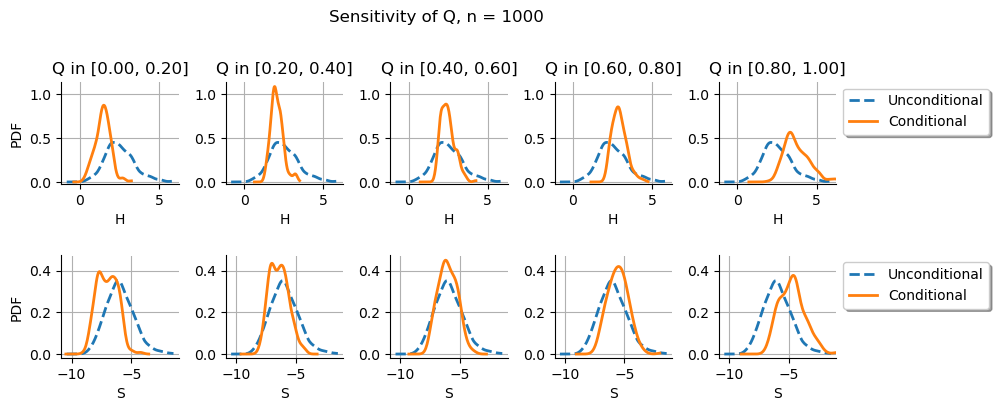

In [5]:
inputMarginalIndex = 0  # See the sensitivity with respect to Q
grid = ots.plotConditionInputAll(
    inputSample,
    outputSample,
    inputMarginalIndex,
)
view = otv.View(
    grid,
    figure_kw={"figsize": (10.0, 4.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
pl.subplots_adjust(wspace=0.4, top=0.8, hspace=0.7)

In [6]:
grid = ots.plotConditionInputQuantileSequence(inputSample, outputSample)
view = otv.View(
    grid,
    figure_kw={"figsize": (12.0, 4.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
pl.subplots_adjust(wspace=0.6, right=0.8, top=0.8, hspace=0.6)

ValueError: The size of the input sample is 1000 which does not match the size of the output sample 199.